# Sparkify Capstone Project

### Executive Summary and Business Overview

Sparkify is Udacity's (on paper...so far) music streaming service, that produces data similar to Spotify or Pandora. User play and/or rate their favorite songs through such services on a daily basis. The business model employed is a free and pay tiered system where free/unpaid users have generally limited access and often using advertisements to offset the royalty fees paid to music artists. Users have the ability to upgrade their service (become a paying customer), or downgrade their service (from paying to non-paying); both tiers have the ability to cancel their service, and that lost of a customer would be considered "customer churn".

All user interaction with Sparkify revolves around these activities:

* Play a song 
* Creating and updating playlists
* Rating song with the thumbs up or thumbs down button
* Add a friend
* Logging in or out
* Changing settings

Each of these activites generates an entry into the user logs. Naturally, log analytics are a key factor for the Sparkify marketing team and all the executive staff.

### Project Objectives

* gain insight into the data 
* understand who is churning 
* what is driving that churn.

## Sparkify Overview

<p>This is my Capstone project, I'll be using Spark to analyze data from user log files from music app Sparkify.</p>

<p>Sparkify is a freeware/payware music app, similar to Pandora or Spotify.  The data we will analyze have contains Sparkify user logs that contain user interaction with the app. The log contains some basic user information as well as essentially click-thru information. Our user community consists of 

* Guests
* Free/non-paying customers
* Paying customer</p>

<p>Our mission is to review and wrangle the data and engineer relevant features for predicting churn. Churn for us means either a Free or Paying customer cancels their service. </p>


In [1]:
# import libraries

from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, isnan, when, isnull, collect_list,udf,countDistinct
from pyspark.sql.types import IntegerType, DateType

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.sql import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("data/mini_sparkify_event_data.json")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
# I moved this up top to show all values of the "auth" field. When I drop the null registrations, "guest"
# and "logged out" will also be dropped

df.select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# How many records and columns?
print("(Number of Records, Number of columns):",((df.count(), len(df.columns))))

(Number of Records, Number of columns): (286500, 18)


In [8]:
# Let's count the number of nulls across the record
# I'm mostly interested in the registration field first, since that is when we first saw a user
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
# This is a little easier to read

print("Columns with Null Values")
for colName, dtype in df.dtypes:
    print(colName,':', df.filter(df[colName].isNull()).count())

Columns with Null Values
artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


#### Missing Values

We can see userAgent, registration, firstName, lastName, location and gender are all have missing values. I'm thinking we should drop those records, let's calculate the percentage.

In [10]:
# Percentage Check
total = float(df.count())
missing = float(df.filter(df.registration.isNull()).count())
percentage = missing *100.0 /total

In [11]:
print('Total Records:', total)
print('Missing Registration:', missing)
print('Percentage of Missing Registration:', percentage)

Total Records: 286500.0
Missing Registration: 8346.0
Percentage of Missing Registration: 2.913089005235602


So less than 3%, so we can drop those records.

In [12]:
# The ever powerful filter. Sort of feel like it needs an "are you sure(y/n)?" option
# https://sparkbyexamples.com/pyspark/pyspark-dataframe-filter/

df_clean = df.filter(df.registration.isNotNull())

In [13]:
# Removed the Missing Registration records
df_clean.count()

278154

In [14]:
# Percentage Check on cleaned 
total = float(df_clean.count())
missing = float(df_clean.filter(df_clean.registration.isNull()).count())
percentage = missing *100.0 /total

In [15]:
# Safety check
print('Total Records:', total)
print('Missing Registration:', missing)
print('Percentage of Missing Registration:', percentage)

Total Records: 278154.0
Missing Registration: 0.0
Percentage of Missing Registration: 0.0


In [16]:
# df now has removed rows
df = df_clean

In [17]:
df.count()

278154

In [18]:
# Check for empty string in UserID. Wanted to make sure we have records that all have user ID. For this study,
# these are the only users we are interested in
# We can see no nulls or empty strings.
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows



In [19]:
# Secondary null check for UID, confirming no nulls
missing_uid = float(df.filter(df.userId.isNull()).count())
print('missing UID:',missing_uid)

missing UID: 0.0


In [20]:
# These are the fields left to
df.toPandas().info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           278154 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  278154 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          278154 non-null  object 
 8   location       278154 non-null  object 
 9   method         278154 non-null  object 
 10  page           278154 non-null  object 
 11  registration   278154 non-null  int64  
 12  sessionId      278154 non-null  int64  
 13  song           228108 non-null  object 
 14  status         278154 non-null  int64  
 15  ts             278154 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         278154 non-nul

In [21]:
df.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [22]:
# Level indicates a paid or free user
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [23]:
# HTTP Methods
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [24]:
# Page types
df.select('page').dropDuplicates().show()
print("Number of page types:", df.select('page').dropDuplicates().count())

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

Number of page types: 19


In [25]:
# Believe this is the code from an HTTP page
df.select('status').dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [26]:
# As mentioned earlier, "guest" and "logged out" were dropped along with null registrations
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [27]:
df.select('userAgent').dropDuplicates().show()
print ("Number of User Agents: ", df.select('userAgent').dropDuplicates().count())

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows

Number of User Agents:  56


In [28]:
# Further refinement

# I've left this in, since it's part of cleaning AND understanding the data. First pass through, I decided
# to drop the records where "registration" was null. It turns out that also dropped out the "Guest" and
# "Logged Out" field. So, the filter below was NOT needed. However, this also shows the iterative nature
# of data understanding. 

# For production code, I would drop this cell. Left in as illustration

# We don't need either Guest or Logged Out records, since there is no churn associated with them. As well, 
# neither field would have a UserID
df = df.filter((df.auth != 'Guest') & (df.auth != 'Logged Out'))
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [29]:
# Review a free user usage
df.filter(df["userId"] == "32").show(10)

+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          RJD2|Logged In|    Diego|     M|            0|   Mckee|237.53098| free|Phoenix-Mesa-Scot...|   PUT|       NextSong|1537167593000|      218|Beyond The Beyond...|   200|1538578897000|"Mozilla/5.0 (iPh...|    32|
| Guns N' Roses|Logged In|    Diego|     M|            1|   Mckee|406.17751| free|Phoenix-Mesa-Scot...|   PUT|      

In [30]:
# Review a paid user
df.filter(df["userId"] == "20").show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+
|                null|Logged In|  Destiny|     F|            0| Herring|     null| paid|Miami-Fort Lauder...|   GET|     Home|1536844410000|      216|                null|   200|1538529207000|"Mozilla/5.0 (Win...|    20|
|Bob Marley & The ...|Logged In|  Destiny|     F|            1| Herring|210.33751| paid|Miami-Fort Lauder...|   PUT|

#### Data Findings


This is my intial set of findings about the dataset. Since the documentation about the log records was not present, potentially this would be updated as more is known about the dataset.

This also presents a minor quandary. What fields/features should I drop, if any, for the upcoming models. In other binary classification problems I've worked on at my job, we tend to leave more in. Especially when there is little to nothing known about the dataset. At present, there are 18 columns. There are potentially a few "easy" ones to drop. For example, I could drop the first and last name. I doubt they will be a very important feature. However, being more inclusive than less is the direction I'm going. 

Here's what has been surmised around a user:
* User Id : User identifier 
* firstName: Users first name
* lastName: Users surname
* gender: either M or F
* location: not known if this comes from the IP address or user provided. Leaning towards from the IP address
* userAgent:  OS/method used to access Sparkify. (57 different categories)
* registration: UNIX/epoch time stamp for presume initial registration
* level: user subscription status (free or paid)

Log details:

* ts : timestamp of a given log  
* page : type of page access (22 categories) 
* auth : authentication status (4 categories) 
* sessionID : what session for the log
* itemInSession : a counter maintained for what looks like a given session
* method : http method
* status : looks like the http status code;

Song details
* song : song name
* artist : artist name
* length: song's length (seconds)


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [31]:
#Review: Cancellation Confirmation is an element of "page"

df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [32]:
# Wanted to use an RDD, but not much covered in the lectures. Came across this:
# Initially thought rdd.map() would work, but went with rdd.flatmap() after reading this:
# https://www.tutorialkart.com/apache-spark/spark-rdd-map-java-python-examples/
# Initially was interested in RDD's since that was the lesson where python vs. SQL was explored. That was one 
# area that I was trying to sort out the difference. Not much SQL in this exercise, but worth exploring later
# down the road in some depth since I do a lot of SQL

# Did we see cancellation confirmation? If so, they have churn and we will assign a 1, otherwise a 0
# Having a binary value makes a variety of analysis easier

churn_users = df.filter(df.page == 'Cancellation Confirmation')\
                                            .select('userId')\
                                            .dropDuplicates()\
                                            .rdd.flatMap(lambda x : x)\
                                            .collect()

In [33]:
# Add in churn column
df = df.withColumn('churn', when(col("userId").isin(churn_users), 1).otherwise(0))

In [34]:
# Check churn column present
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


#### Churn Defined

* 1 - users who cancelled their subscription within the observation period
* 0 - users who kept the service throughout


In [35]:
# Unique churn
# Will add more visualization, just want to get a quick check
# 173 users kept service
# 52 users churned

# Here's an interesting conundrum. How to be convey/display the values around Churn. For our purposes of 
# picking features and model development, I set a value of 0 and 1 to indicate not/did churn. Fine for those functions
# where numeric values are useful/required, that's great. 
# However, this is why I find visualization helpful. I can be more descriptive in the visualization that 
# a raw number display like below. 
# Yes, I could have added yet another column, something like "yes/no" to indicate churn, or do some sort of 
# transformation prior to printing. But for me, I lean toward visualizations 

dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [36]:
# Use a temporary DataFrame to do some Pandas specific EDA
temp_df = df.toPandas()

#### EDA Visualizations

In general, I do most of my EDA visually. Possibly since I use a variety of data quality tools at work that have a lot of data wrangling capabilities, but here are a set that I used to further explore the dataset

#### Battle of the visualizations

I've used both Seaborn and Matplotlib here. I tend more towards using Matplotlib these days, since it conveys information both visually and quickly. My experience with Seaborn, while generally favorable, is that I spend more time that likely is necessary to create something that is visually "eye-candy", but in the end conveys the same information as Matplotlib. 



#### Spark Programming
 
While the lectures and example programs were helpful, I found these references helpful. I found that "drop_duplicates" was a pretty handy function, below is some more detail on that I found helpful.

Helpful spark info: https://sparkbyexamples.com/spark/spark-remove-duplicate-rows/

And of course the reference info: http://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html

All of that said, first EDA check shows that more cust

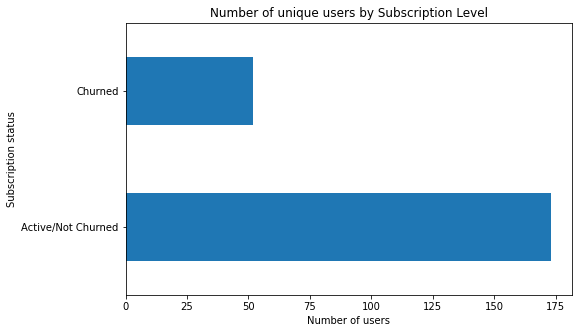

In [37]:
# Visualize the users churned
ax = temp_df.drop_duplicates(subset='userId').groupby('churn')['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Number of unique users by Subscription Level');
ax.set_xlabel('Number of users');
ax.set_yticklabels(['Active/Not Churned', 'Churned'], rotation=0)
ax.set_ylabel("Subscription status");

# Test    
#plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

Note: For ease of reading, I will refer to Not Churned users as Active now

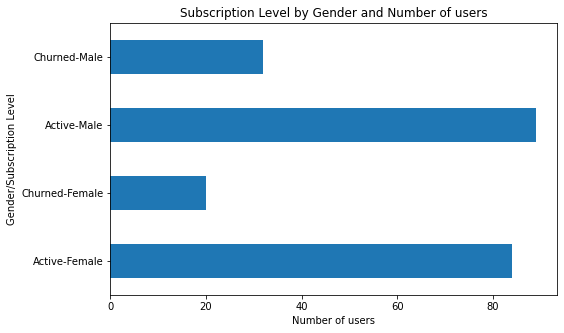

In [38]:
# Churn by visualization of gender

df_gen = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
ax = temp_df.drop_duplicates(subset=['userId', 'gender']).groupby(['gender', 'churn'])['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Subscription Level by Gender and Number of users');
ax.set_xlabel('Number of users');
ax.set_yticklabels(['Active-Female', 'Churned-Female', 'Active-Male', 'Churned-Male'], rotation=0)
ax.set_ylabel("Gender/Subscription Level");

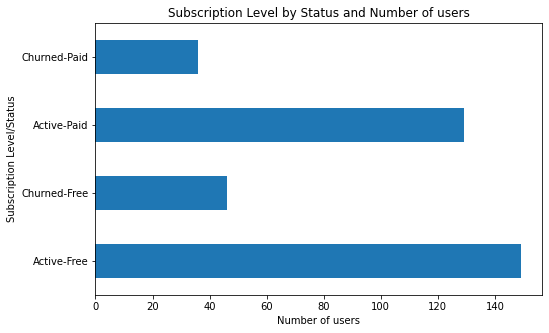

In [39]:
# Visualize by churn and subscription 
ax = temp_df.drop_duplicates(subset=['userId', 'level']).groupby(['level', 'churn'])['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Subscription Level by Status and Number of users');
ax.set_xlabel('Number of users');
ax.set_yticklabels(['Active-Free', 'Churned-Free', 'Active-Paid', 'Churned-Paid'], rotation=0)
ax.set_ylabel("Subscription Level/Status");

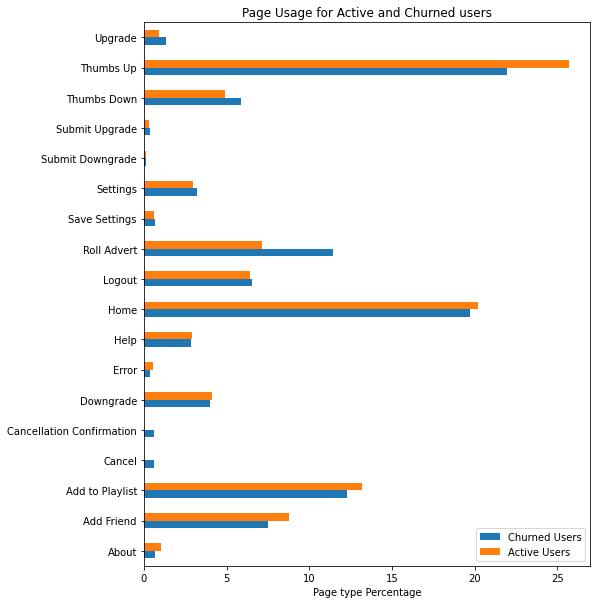

In [40]:
# Page Analysis 
# I used percentage as a comparison, otherwise the bar length is too small
users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Churned Users': users_1,'Active Users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Page type Percentage')
ax.set_title('Page Usage for Active and Churned users');



In [41]:
#Time for a little Spark SQL. I need to create a temp SQL view

df.createOrReplaceTempView("sql_view_table")


In [42]:
number_of_sessions = spark.sql("SELECT userId, avg(count) as average from (SELECT userId, count(*) as count FROM sql_view_table group by sessionId, userId) group by userId")

In [43]:
churned_users = list(dfp[dfp['page'] == 'Cancellation Confirmation']['userId'].unique())

In [44]:
churned_users.sort()

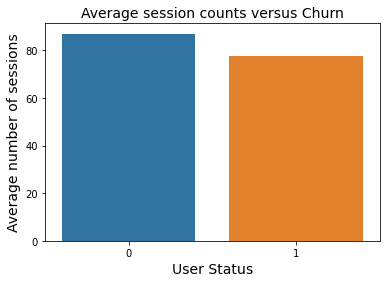

In [45]:
pd_num_sessions = number_of_sessions.toPandas()
pd_num_sessions['churn'] = pd_num_sessions['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.barplot(x="churn", y="average", data=pd_num_sessions, ci=None);
plt.xlabel("User Status", fontsize=14);
plt.ylabel("Average number of sessions", fontsize=14);
plt.title("Average session counts versus Churn", fontsize=14);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

After analyzing all the column above i have decided to use below fetaure in my model:<br/>
1:- Gender<br/>
2:- UserAgent<br/>
3:- Status<br/>
4;- Page<br/>

<p>Once the columns were identified, we now have to make sure that they are al in the numeric datatype so that they could be put into the model that we choose. The Gender, UserAgent and page columns had to be converted into numeric values using a combination of String Indexing and One Hot encoding.</p>


#### Helpful Extract and Transform links

https://spark.apache.org/docs/2.3.0/ml-features.html
    
Super helpful guide here: https://towardsdatascience.com/feature-encoding-with-spark-2-3-0-part-1-9ede45562740

Part 2 was good too: https://towardsdatascience.com/feature-encoding-made-simple-with-spark-2-3-0-part-2-5bfc869a809a

        

In [46]:
#build pipeline
# Vector assembly: combine the raw features and features generated from various transforms into a single feature vector
# I like this guy in general for his ML blogs, and this is a good one on one-hot encoding:
# https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
# And everything you ever want to know about one-hot and categorical data:
# https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

Gender_one_hot = OneHotEncoder(inputCol='Gender_Index', outputCol='Gender_Vec')
User_one_hot = OneHotEncoder(inputCol='User_Index', outputCol='User_Vec')
Page_one_hot = OneHotEncoder(inputCol='Page_Index', outputCol='Page_Vec')

# Use String Indexer to set up label indices for Gender, User agent, and Page type
# I define Target_indexer as the binary field to be determined (Churn = yes or no?)

Gender_ndx = StringIndexer(inputCol="gender", outputCol='Gender_Index')
User_ndx = StringIndexer(inputCol="userAgent", outputCol='User_Index')
Page_ndx = StringIndexer(inputCol="page", outputCol='Page_Index')
Target_indexer = StringIndexer(inputCol="churn", outputCol="label")
# Get single vector column for our binary classification models
assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec", "status"], outputCol="features")


In [47]:
assembler

VectorAssembler_b64f7d9e8f3c

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

##### Model choices

We have a simple but key business need here. Answer the binary yes or no question: "Will a customer churn?". This represents a dynamic on two important fronts:

1) How can we keep existing customers from churning
2) How can we prevent future customer from churning

There is also a another key question that would require potentially more data and analysis which is "How can we get free customers to become paid customers?". As they saying goes, that is beyond the scope of this exericse. However, that would be my next step. 

Back to the question at hand, how to prevent churn. I've chosen two good classification models to use for this exercise:

* Logistic regression
* Random Forest 


#### Some references

https://spark.apache.org/docs/2.3.0/ml-classification-regression.html

https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/

https://spark.apache.org/docs/2.3.0/ml-pipeline.html

https://projector-video-pdf-converter.datacamp.com/14989/chapter4.pdf

https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning

http://spark.apache.org/docs/2.3.0/ml-tuning.html



In [48]:
# Set up the Logistic Regression model
# I used the parameters in the Spark programming guide. 
# https://spark.apache.org/docs/2.3.0/ml-classification-regression.html#binomial-logistic-regression
# Pipeline code suggestions from here: https://spark.apache.org/docs/2.3.0/ml-pipeline.html

lr =  LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0)
pipeline = Pipeline(stages=[Gender_ndx, User_ndx, Page_ndx, Gender_one_hot,
                            User_one_hot, Page_one_hot, assembler, Target_indexer, lr])

In [49]:
# Set up test and training data with the pyspark randomsplit function
# From here: https://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html
# Use 90% training, 10% test. We've used 42 as the random seed before

test_set, validation = df.randomSplit([0.9, 0.1], seed=42)

In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [51]:
# Use Paramgrid builder to create a search grid
# Crossvalidator will create 3 folds for evaluating the pipeline
# Helpful code here: https://spark.apache.org/docs/2.3.0/ml-tuning.html
# NOTE: I was a little puzzled/interested when I compared the Binary Classification Evaluator to the 
#       Multiclass Evaluator, as the Binary Evaluator was roughly 2% better. 
#       I know the lectures used Multiclass though.

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, ]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [52]:
# Run the cross-validation, and choose the best set of parameters.
cvModelLR = crossval.fit(test_set)

In [53]:
# Drum roll.... Display the values from the Cross Valuation ML run
cvModelLR.avgMetrics

[0.8511568613231526, 0.8537100336624815]

In [54]:
results_lr = cvModelLR.transform(test_set)

In [55]:
print("Accuracy for Logistic Regression Model is: ", results_lr.filter(results_lr.label == results_lr.prediction).count()/ results_lr.count())

Accuracy for Logistic Regression Model is:  0.8820300796932111


In [56]:
evaluator = MulticlassClassificationEvaluator(metricName="f1")

In [57]:
score = evaluator.evaluate(results_lr)

In [58]:
print("F1 score for Logistic Regression model is : ", score)

F1 score for Logistic Regression model is :  0.8537909031115947


In [59]:
# Set up the Random Forest model
# I used the parameters in the Spark programming guide. 
# https://spark.apache.org/docs/2.3.0/ml-classification-regression.html#multinomial-logistic-regression
# Pipeline code suggestions from here: https://spark.apache.org/docs/2.3.0/ml-pipeline.html
# Good info and code suggestions for Random Forest: 
#https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

rf = RandomForestClassifier(labelCol="label",\
                            featuresCol="ScaledFeatures",\
                            featureSubsetStrategy='sqrt')

# creating pipeline
pipeline_rf = Pipeline(stages=[Gender_ndx, User_ndx, Page_ndx, Gender_one_hot,
                            User_one_hot, Page_one_hot, assembler, Target_indexer, lr])

# Build parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .addGrid(rf.numTrees,[10, 25, 50, 100]) \
    .build()

# Cross validation evaluates
crossval_rf = CrossValidator(estimator=pipeline_rf,\
                             estimatorParamMaps=paramGrid,\
                             evaluator=MulticlassClassificationEvaluator(),\
                             numFolds=3)

# This was an interesting read on the fit funtionality
# https://www.timlrx.com/2018/04/08/creating-a-custom-cross-validation-function-in-pyspark/

cvModelRf = crossval_rf.fit(test_set)
resultsRf = cvModelRf.transform(validation)

In [60]:
cvModelRf.avgMetrics

[0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266,
 0.783937966294266]

In [61]:
evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(resultsRf)
print("F1 score for Random Forest model is : ", score)

F1 score for Random Forest model is :  0.7861464794022486


In [62]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
score = evaluator.evaluate(resultsRf)
print("Accuracy score for Random Forest model is : ", score)

Accuracy score for Random Forest model is :  0.8481253819332111


In [63]:
# Need to use Binary Classification Evaluator
auc_evaluator = BinaryClassificationEvaluator()
metric_value = auc_evaluator.evaluate(resultsRf, {auc_evaluator.metricName: "areaUnderROC"})
print('The areaUnderROC on the test set is {:.2%}'.format(metric_value))

The areaUnderROC on the test set is 86.71%


In [64]:
print('Number of models to be tested: ', len(paramGrid))

Number of models to be tested:  32


# Conclusion

We have a starting point with our Logistic Regression model with the F1 score of .85. As suggested, we'll use the F1 score as the intial criteria. 

With customer churn, the historical data is golden as we know who did and did not churn. Our data set offers us this as the basis for training our model, and we have two immediate actions we can take:

1) Look at the current customers and create an assessment of who will be likely to churn based on using our model. Those customers may need some further incentive to stay, such as a financial incentive for our paying customers and a reduction in ad frequency for our free customers.

2) Examine all new customers and make an assessment of their likelyhood to churn.

Sparkify managment also needs to review their free customer paradigm. We were not provided the data the shows how profitable free vs. paying customer are. It's not a simple choice to say that Sparkify makes more money on the paying customers over the free customers. Potentially the ad revenue compensates more than the pay revenue; the record/music companies that supply Sparkify their music to play may offer financial incentives based on advertisement. There are many factors in play here.

Should paying customer generate more revenue than free customers, the next model set to be built and tested would be building a prediction model to determine propensity to upgrade. Our dataset provides a good starting point for that, again that would be a binary classification problem ("Did the customer upgrade: Yes or No?")

Sparkify appears to be an active site; there are a lot of songs being played, playlists created, and friends added. All of those are potential features to continue to mine and refine. This is all part of the ML discovery process. 

Pyspark and Big Data are also key elements of the technology here. Being able to assess large volumes of data via Hadoop, HDFS, and Spark represents an ability to keep tied into the Sparkify user community in an accurate and also fairly inobstrusive way via log data analysis. 

Data Privacy is an element that should likely be addressed as well, as the log data set includes both name and location data. There are a number of useful data obfuscation/anonymization techniques available. Sparkify would be advised to review their data privacy policies. 

Lastly, Pyspark represents a very useful way of approaching Big Data programming married with the efficiency and ease of Python programming. In the world of Data Science, both Python and SQL programming skills are both useful to have and faily plentiful in the labor market. 

Sparkify is off to a good start with the approach to both Big Data and Data Science!

# Improvement

These are the next areas I would improve this exercise with:

1) Tuning
Here's a great guide: https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc
and here: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

2) Cracking the code on displaying a good, readable, "most important features" list. Here is a good start:

https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

3) Add more metrics for analysis

There are a lot of good metrics and evaluation metrics from MulticlassMetrics. You'll need to include: 

"from pyspark.mllib.evaluation import MulticlassMetrics"

Here are some good references and code samples for getting further details

https://spark.apache.org/docs/2.3.0/api/python/_modules/pyspark/mllib/evaluation.html

and a potpourri of evaluation metrics: https://spark.apache.org/docs/2.3.0/mllib-evaluation-metrics.html

4) Sparkify needs to review their data privacy program. Good info on Python and data obfuscation/redaction:

https://medium.com/district-data-labs/a-practical-guide-to-anonymizing-datasets-with-python-faker-ecf15114c9be

https://towardsdatascience.com/revolutionising-redaction-my-final-year-project-fe664e28ef84

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.